In [ ]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0


In [ ]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 47kB/s 
     |████████████████████████████████| 3.8MB 34.8MB/s 
     |████████████████████████████████| 450kB 68.4MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import os 

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import random


In [ ]:
'''
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

'''
version = tf.__version__
gpu_ok = tf.test.is_gpu_available()

print("tf version:",version,"\nuse GPU",gpu_ok)


tf version: 2.0.0 
use GPU True


In [ ]:
print("Loading data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size = 0.33, random_state = 42)
x_train = x_train[y_train==3]
x_val = x_val[y_val==3]

img_size = x_train.shape[1]
x_train = x_train.reshape((-1, img_size * img_size))
x_test = x_test.reshape((-1, img_size * img_size))

train_buf = x_train.shape[0]
print(x_train.shape)
print(train_buf)
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

Loading data...
11493376/11490434 [==============================] - 0s 0us/step
(4096, 784)
4096


In [ ]:
n, p = x_train.shape
d = 32
B = 100 # Bin
fm_list = [32, 32, 32, 32]

In [ ]:
def downsampleblock(input_, h_dim):
    x = tf.keras.layers.Conv2D(h_dim, (3, 3), strides = 1, padding='same', use_bias = True)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(h_dim, (1, 1), strides = 2, padding='valid', use_bias = True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    y = tf.keras.layers.Conv2D(h_dim, (3, 3), strides = 2, padding='same', use_bias = True)(input_)
    y = tf.keras.layers.BatchNormalization()(y)
    
    o = tf.keras.layers.Add()([x, y])
    o = tf.keras.layers.LeakyReLU()(o)
    return o

def upsampleblock(input_, h_dim):
    x = tf.keras.layers.Conv2DTranspose(h_dim, (5, 5), strides=1, padding='same', use_bias = True)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(h_dim, (1, 1), strides=2, padding='same', use_bias = True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    y = tf.keras.layers.Conv2D(h_dim, (3, 3), strides=1, padding='same', use_bias = True)(input_)
    y = tf.keras.layers.UpSampling2D((2, 2))(y)
    y = tf.keras.layers.BatchNormalization()(y)
    
    o = tf.keras.layers.Add()([x, y])
    o = tf.keras.layers.LeakyReLU()(o)
    return o

def residualblock(input_):
    x = tf.keras.layers.Conv2D(h_dim[0], (3, 3), strides=1, padding='same')(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(h_dim[0], (3, 3), strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    o = tf.keras.layers.Add()([x, input_])
    o = tf.keras.layers.LeakyReLU()(o)
    return o

In [ ]:
def MaskedFullyConnection(x, w, mask_type = 'B'):

    _, d, c_in = x.shape
    d_co, _ = w.shape  #w.shape = (c_out*d) * (c_in*d)
    c_out = d_co//d

    x = tf.reshape(x, [-1, d * c_in] )

    mask_0 = tf.zeros_like(w)
    mask_1 = tf.ones_like(w)
    j = 0
    for f in range(d):
        start_row = f * c_out
        end_row = (f+1) * c_out
        start_col = 0
        end_col = f * c_in if mask_type == 'A' else (f+1) * c_in
        '''相當於mask[start_row:end_row, start_col:end_col] = 1；其他是0 '''
        sub_mask_1 = mask_1[start_row:end_row, start_col:end_col]
        sub_mask_0 = mask_0[start_row:end_row, end_col:]
        sub_mask = tf.concat([sub_mask_1,sub_mask_0], axis = 1)
        if j==0:
            mask = sub_mask
        else:
            mask = tf.concat([mask,sub_mask], axis = 0)
        j = j + 1
    mask_w = tf.multiply(mask, w)
    mask_w = tf.transpose(mask_w, [1,0]) #(c_in*d) * (c_out*d)
    output = tf.matmul(x, mask_w)
    output = tf.reshape(output, [-1, d , c_out] ) ##x = N*d*c
    

                            
    return output

In [ ]:
class MFC(layers.Layer):
    def __init__(self, mask_type = 'B', c_in = 1, c_out = 5, latent_dim = d):
        super(MFC, self).__init__()
        self.w = self.add_weight(shape=(latent_dim * c_out, latent_dim * c_in), initializer='random_normal', trainable=True)
        self.type = mask_type
    def call(self, inputs):
        output = MaskedFullyConnection(inputs, self.w, self.type )
        output = tf.nn.relu(output)
        return output


In [ ]:
def make_encoder():

    inputs = tf.keras.Input(shape=(p,), name='inputs')
    x = tf.reshape(inputs, shape = (-1, img_size, img_size, 1))
    #print(x.shape)
    x = downsampleblock(x, d)
    #print(x.shape)
    x = downsampleblock(x, d)
    #print(x.shape)
    x = tf.reshape(x, shape = (-1, 7 * 7 * d))
    #print(x.shape)
    
    x = tf.keras.layers.Dense(d*2)(x)
    #print(x.shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(d, activation='sigmoid')(x)
    #print(x.shape)
    print("")
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    
   
def make_decoder():

    inputs = tf.keras.Input(shape=(d,), name='inputs')
    #print(inputs.shape)
    x = tf.keras.layers.Dense(d*2)(inputs)
    #print(x.shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(d*7*7)(x)
    #print(x.shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.reshape(x, shape = (-1, 7, 7, d))
    #print(x.shape)
    x = upsampleblock(x, d)
    #print(x.shape)
    x = upsampleblock(x, d)
    #print(x.shape)
    x = tf.keras.layers.Conv2D(1, (1, 1), strides=1, padding='same')(x)
    #print(x.shape)
    x = tf.reshape(x, shape = (-1, p))
    #print(x.shape)
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model 
        
        
def make_estimator():      
    inputs = tf.keras.Input(shape=(d,), name='inputs')
    print('make_estimator')

    x = tf.expand_dims(inputs, axis=2)
    #print(x.shape)
    x = MFC('A', 1, fm_list[0])(x)
    #print(x.shape)
    x = MFC('B',fm_list[0],fm_list[1])(x)
    #print(x.shape)
    x = MFC('B',fm_list[1],fm_list[2])(x)
    #print(x.shape)
    x = MFC('B',fm_list[2],fm_list[3])(x)
    #print(x.shape)
    x = MFC('B',fm_list[3],B)(x)
    #print(x.shape)
    x = tf.nn.softmax(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

encoder = make_encoder()
decoder = make_decoder()
estimator = make_estimator()


make_estimator


In [ ]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 784)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 28, 28, 1)]  0           inputs[0][0]                     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 64)           256         dense_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 64)           0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

In [ ]:
estimator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 32)]              0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 32, 1)]           0         
_________________________________________________________________
mfc (MFC)                    (None, 32, 32)            32768     
_________________________________________________________________
mfc_1 (MFC)                  (None, 32, 32)            1048576   
_________________________________________________________________
mfc_2 (MFC)                  (None, 32, 32)            1048576   
_________________________________________________________________
mfc_3 (MFC)                  (None, 32, 32)            1048576   
_________________________________________________________________
mfc_4 (MFC)                  (None, 32, 100)           3276

In [ ]:
REC_loss_weight = 1
LLK_loss_weight = 0.01

cross_entropy = tf.keras.losses.CategoricalCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def REC_loss(inputs, reconstruction):
    return  mse(inputs, reconstruction)

def LLK_loss(z, z_dist):
    '''
    z : encoder後的結果 N * d (hidden layer units)  
    z_dist : autoregressive後的結果 N * d * B 
    
    '''
    eps = 1e-16
    batch = z.shape[0]
    z_dist = tf.clip_by_value(z_dist, eps, 1 - eps)
    log_z_dist = tf.math.log(z_dist)

    indices = tf.histogram_fixed_width_bins(z, [0.0, 1.0], nbins = B)
    indices = tf.one_hot(indices, B)

    loss = cross_entropy(y_true = indices, y_pred = log_z_dist)

    return loss


In [ ]:
base_lr = 1e-6
max_lr = 1e-4

n_samples = len(x_train)
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0   

m_optimizer = tf.keras.optimizers.Adam(lr=base_lr)

In [ ]:
@tf.function
def update_model(batch_x):

    with tf.GradientTape() as m_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(encoder_output, training=True)

        cpd = estimator(encoder_output, training=True)
        
        rec_loss = REC_loss(batch_x, decoder_output)
        llk_loss = LLK_loss(encoder_output, cpd)  
        total_loss = LLK_loss_weight * llk_loss + REC_loss_weight * rec_loss

    m_grads = m_tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables + estimator.trainable_variables)
    m_optimizer.apply_gradients(zip(m_grads, encoder.trainable_variables + decoder.trainable_variables + estimator.trainable_variables))
    
    return rec_loss, llk_loss, total_loss


In [ ]:
n_epochs = 7500
start = 0
tolerance = 0

rec_loss_list = []
llk_loss_list = [] 
total_loss_list = []
pre_loss = np.inf

checkpoint_dir = 'train'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
for epoch in range(n_epochs):
    
    if epoch % 1000 == 0 :
        try:
            checkpoint = tf.train.Checkpoint(model = model)
            #latest = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
            checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

            print('load!!')
            
        except:
            print('continue')
    start = time.time()
    
    if epoch in [5000, 10000, 100000]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')
    
    epoch_rec_loss_avg = tf.metrics.Mean()
    epoch_llk_loss_avg = tf.metrics.Mean()
    epoch_total_loss_avg = tf.metrics.Mean()

    for batch, (batch_x) in enumerate(train_dataset):

        rec_loss, llk_loss, total_loss = update_model(batch_x)
        
        epoch_rec_loss_avg(rec_loss)
        epoch_llk_loss_avg(llk_loss)
        epoch_total_loss_avg(total_loss)
        
    rec_loss_list.append(rec_loss)
    llk_loss_list.append(llk_loss)
    total_loss_list.append(total_loss)

    epoch_time = time.time() - start
    if epoch % 100 == 0:

        print('{:4d}: TIME: {:.2f} rec_loss: {:} llk_loss: {:} total_loss: {:}' \
          .format(epoch, epoch_time,
                  epoch_rec_loss_avg.result(),
                  epoch_llk_loss_avg.result(),
                  epoch_total_loss_avg.result()))
        if pre_loss < epoch_llk_loss_avg.result():
            tolerance +=1
            if tolerance==0:
                checkpoint = tf.train.Checkpoint(optimizer = m_optimizer)
                checkpoint.save(file_prefix = checkpoint_prefix)
            
            if tolerance==3:
                rec_loss_list.pop([-300])
                llk_loss_list.pop([-300])
                total_loss_list.pop([-300])
                break
        else:
            tolerance = 0
            
        if abs(epoch_llk_loss_avg.result()-pre_loss) < 1e-8:
            break
        else:
            pre_loss = epoch_llk_loss_avg.result()


continue
   0: TIME: 13.17 rec_loss: 3.3181891441345215 llk_loss: 4.605199337005615 total_loss: 3.364241123199463
 100: TIME: 0.57 rec_loss: 1.0145379304885864 llk_loss: 4.605106830596924 total_loss: 1.060589075088501
 200: TIME: 0.59 rec_loss: 0.326810747385025 llk_loss: 4.605007648468018 total_loss: 0.372860848903656
 300: TIME: 0.57 rec_loss: 0.12752367556095123 llk_loss: 4.604874610900879 total_loss: 0.17357243597507477
 400: TIME: 0.57 rec_loss: 0.07282930612564087 llk_loss: 4.604641437530518 total_loss: 0.11887571960687637
 500: TIME: 0.57 rec_loss: 0.05477648228406906 llk_loss: 4.604190349578857 total_loss: 0.10081837326288223
 600: TIME: 0.57 rec_loss: 0.04703836888074875 llk_loss: 4.60325288772583 total_loss: 0.09307089447975159
 700: TIME: 0.59 rec_loss: 0.042483970522880554 llk_loss: 4.601064205169678 total_loss: 0.08849462121725082
 800: TIME: 0.59 rec_loss: 0.039674703031778336 llk_loss: 4.596041679382324 total_loss: 0.08563511073589325
 900: TIME: 0.58 rec_loss: 0.0377319

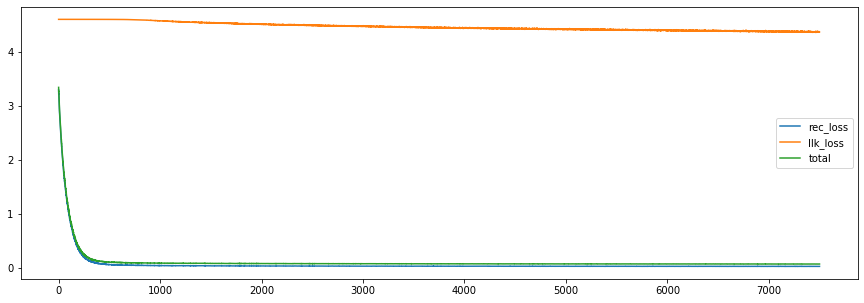

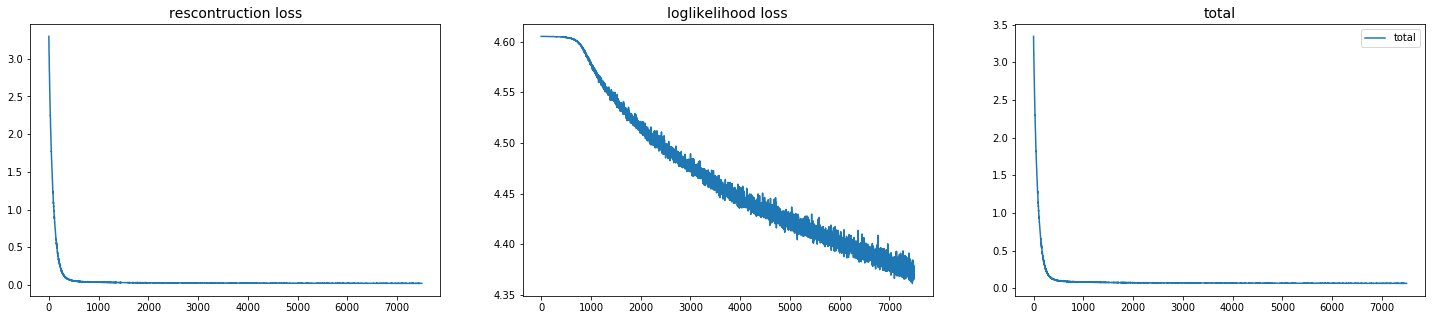

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rec_loss_list, label = 'rec_loss')
plt.plot(llk_loss_list, label = 'llk_loss')
plt.plot(total_loss_list, label = 'total')
plt.legend()
plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25, 5))
ax1.set_title('rescontruction loss', fontsize=14)
ax1.plot(rec_loss_list, label = 'rec_loss')
ax2.set_title('loglikelihood loss', fontsize=14)
ax2.plot(llk_loss_list, label = 'llk_loss')
ax3.set_title('total', fontsize=14)
ax3.plot(total_loss_list, label = 'total')
plt.legend()

In [ ]:
def result_model(batch_x):

    encoder_output = encoder(batch_x, training = False)
    decoder_output = decoder(encoder_output, training = False)

    cpd = estimator(encoder_output, training = False)

    rec_loss = REC_loss(batch_x, decoder_output)
    llk_loss = LLK_loss(encoder_output, cpd)  
    
    return rec_loss, llk_loss

In [ ]:
def compute_normalizing_coefficients(x_val):
    # type: (int) -> Tuple[float, float, float, float]
    """
    Computes normalizing coeffients for the computation of the Novelty score (Eq. 9-10).
    :param cl: the class to be considered normal.
    :return: a tuple of normalizing coefficients in the form (llk_min, llk_max, rec_min, rec_max).
    """

    sample_llk = np.zeros(shape=(len(x_val),))
    sample_rec = np.zeros(shape=(len(x_val),))
    for i in range(len(x_val)):
        
        loss_rec, loss_llk = result_model(x_val[i].reshape(-1, img_size * img_size))

        sample_llk[i] = - loss_llk
        sample_rec[i] = - loss_rec 
        i = i + 1
    
    return sample_llk.min(), sample_llk.max(), sample_rec.min(), sample_rec.max()

In [ ]:
def novelty_score(sample_llk_norm, sample_rec_norm):
    # type: (np.ndarray, np.ndarray) -> np.ndarray
    """
    Computes the normalized novelty score given likelihood scores, reconstruction scores
    and normalization coefficients (Eq. 9-10).
    :param sample_llk_norm: array of (normalized) log-likelihood scores.
    :param sample_rec_norm: array of (normalized) reconstruction scores.
    :return: array of novelty scores.
    """

    # Sum
    ns = sample_llk_norm + sample_rec_norm

    return ns

In [ ]:
def normalize(samples, min, max):
    # type: (np.ndarray, float, float) -> np.ndarray
    """
    Normalize scores as in Eq. 10
    :param samples: the scores to be normalized.
    :param min: the minimum of the desired scores.
    :param max: the maximum of the desired scores.
    :return: the normalized scores
    """
    return (samples - min) / (max - min)

In [ ]:
def Detection(label, x_test, y_test, x_val):
    
    min_llk, max_llk, min_rec, max_rec = compute_normalizing_coefficients(x_val)
    
    sample_llk = np.zeros(shape=(len(x_test),))
    sample_rec = np.zeros(shape=(len(x_test),))
    sample_y = np.zeros(shape=(len(x_test),))
    for i in range(len(x_test)):
        
        loss_rec, loss_llk = result_model(x_test[i].reshape(-1, img_size * img_size))

        sample_llk[i] = - loss_llk
        sample_rec[i] = - loss_rec
        sample_y[i] = (y_test[i] == label)
        i = i + 1
    

    # Normalize scores
    sample_llk = normalize(sample_llk, min_llk, max_llk).astype('f')
    sample_rec = normalize(sample_rec, min_rec, max_rec).astype('f')

    # Compute the normalized novelty score
    sample_ns = novelty_score(sample_llk, sample_rec).astype('f')

    # Compute AUROC for this class
    this_class_metrics = [
        roc_auc_score(sample_y, sample_llk),  # likelihood metric
        roc_auc_score(sample_y, sample_rec),  # reconstruction metric
        roc_auc_score(sample_y, sample_ns)    # novelty score
    ]
    return  this_class_metrics

In [ ]:
Detection(3, x_test, y_test, x_val)

[0.6478294915142238, 0.8675269551426779, 0.8302052335378144]